In [1]:
# !pip install xgboost

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from xgboost import XGBRegressor,XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error, r2_score,accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import math
from imblearn.under_sampling import RandomUnderSampler

## 1- Loading Data

In [3]:
path = "../data/fraud_detection_dataset.csv"
data = pd.read_csv(path)

## 2- Inspecting Data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   account_open_date                        7000 non-null   object 
 1   age                                      7000 non-null   int64  
 2   location                                 7000 non-null   object 
 3   occupation                               7000 non-null   object 
 4   income_level                             7000 non-null   int64  
 5   fico_score                               6790 non-null   float64
 6   delinquency_status                       7000 non-null   int64  
 7   charge_off_status                        7000 non-null   bool   
 8   number_of_credit_applications            7000 non-null   int64  
 9   debt_to_income_ratio                     7000 non-null   float64
 10  payment_methods_high_risk                7000 no

In [5]:
data.head()

,account_open_date,age,location,occupation,income_level,fico_score,delinquency_status,charge_off_status,number_of_credit_applications,debt_to_income_ratio,...,number_of_delinquent_accounts,number_of_defaulted_accounts,earliest_credit_account,recent_trade_activity,new_accounts_opened_last_12months,multiple_applications_short_time_period,unusual_submission_pattern,applications_submitted_during_odd_hours,watchlist_blacklist_flag,public_records_flag
0,11/9/2023,56,Los Angeles,Teacher,40099,424.0,108,True,10,3.139572,...,4.0,2,9/11/2018,3/7/2024,3,True,True,False,False,True
1,9/11/2022,69,New York,Engineer,2050,483.0,0,False,1,1.017489,...,3.0,2,3/8/2023,1/28/2024,3,False,True,False,False,False
2,7/12/2020,46,Miami,Engineer,71936,566.0,0,False,1,1.508626,...,2.0,0,4/26/2024,10/3/2024,2,False,False,False,False,False
3,8/13/2024,32,Houston,Banker,15833,NaN,97,True,5,2.995150,...,3.0,1,9/14/2023,10/14/2024,4,False,True,True,False,False
4,7/27/2024,60,Houston,Lawyer,8574,787.0,0,False,1,1.182380,...,NaN,0,11/8/2022,9/2/2024,0,True,False,True,False,False


In [6]:
data.describe()

,age,income_level,fico_score,delinquency_status,number_of_credit_applications,debt_to_income_ratio,max_balance,avg_balance_last_12months,number_of_delinquent_accounts,number_of_defaulted_accounts,new_accounts_opened_last_12months
count,7000.000000,7000.000000,6790.000000,7000.000000,7000.000000,7000.000000,7000.000000,6650.000000,6300.000000,7000.000000,7000.000000
mean,46.208857,23739.063714,616.424448,25.226714,1.813000,1.477630,50337.829377,33638.208194,1.212857,0.499143,1.382429
std,16.401828,21846.844041,132.567079,42.709195,1.934719,0.687469,49507.198629,22358.889181,1.558081,0.729435,1.594714
min,18.000000,2000.000000,152.000000,0.000000,1.000000,0.438413,930.516529,457.869809,0.000000,0.000000,0.000000
25%,32.000000,6927.250000,520.000000,0.000000,1.000000,1.052709,25496.283316,13699.263133,0.000000,0.000000,0.000000
50%,46.000000,15014.000000,636.000000,0.000000,1.000000,1.320565,44679.410787,30352.353060,0.000000,0.000000,0.000000
75%,61.000000,38299.750000,723.000000,29.000000,1.000000,1.720369,70157.462957,52039.232172,3.000000,1.000000,3.000000
max,74.000000,99957.000000,943.000000,119.000000,10.000000,9.975930,999922.083300,92117.793445,4.000000,2.000000,4.000000


## 4- Converting Data Types

In [7]:
# Date conversions
data['account_open_date'] = pd.to_datetime(data['account_open_date'])
data['earliest_credit_account'] = pd.to_datetime(data['earliest_credit_account'])
data['recent_trade_activity'] = pd.to_datetime(data['recent_trade_activity'])

In [8]:
# Categorical conversions
data['location'] = data['location'].astype('category')
data['occupation'] = data['occupation'].astype('category')

In [9]:
# Boolean to 0,1 convention 
data['multiple_applications_short_time_period'] = data['multiple_applications_short_time_period'].astype(int)
data['watchlist_blacklist_flag'] = data['watchlist_blacklist_flag'].astype(int)
data['public_records_flag'] = data['public_records_flag'].astype(int)
data['applications_submitted_during_odd_hours'] = data['applications_submitted_during_odd_hours'].astype(int)
data['payment_methods_high_risk'] = data['payment_methods_high_risk'].astype(int)
data['charge_off_status'] = data['charge_off_status'].astype(int)

## 3- Handling Missing Values

In [10]:
# Summary of missing values in each column
missing_summary = data.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

unusual_submission_pattern       910
number_of_delinquent_accounts    700
avg_balance_last_12months        350
fico_score                       210
dtype: int64


### 3.1 - `avg_balance_last_12months`

Mean: 33638.20819360806
Median: 30352.353060193185
Standard Deviation: 22358.889181084403
Skewness: 0.40219292066235507
Kurtosis: -0.9413789598163418


C:\Users\hcham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


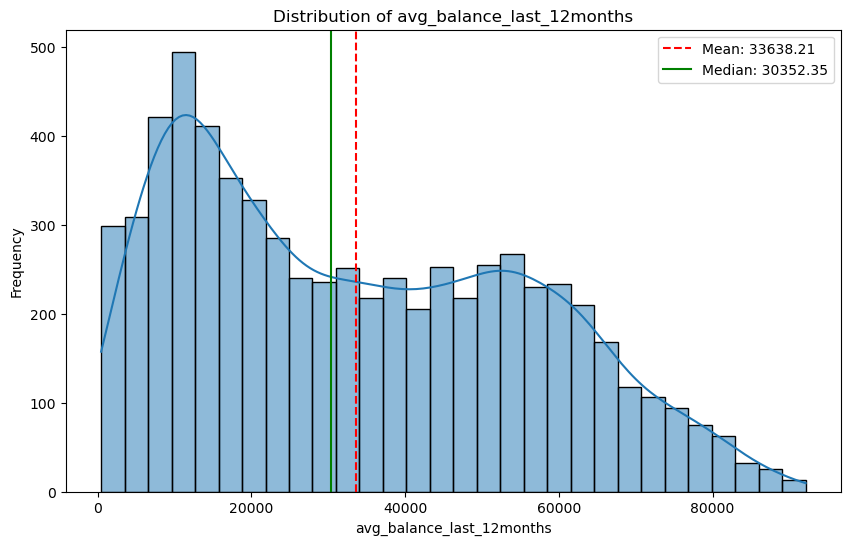

In [11]:
mean_value = data['avg_balance_last_12months'].mean()
median_value = data['avg_balance_last_12months'].median()
std_dev = data['avg_balance_last_12months'].std()
skewness = data['avg_balance_last_12months'].skew()
kurtosis = data['avg_balance_last_12months'].kurt()

print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_dev}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

plt.figure(figsize=(10, 6))
sns.histplot(data['avg_balance_last_12months'], kde=True, bins=30)
plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='g', linestyle='-', label=f'Median: {median_value:.2f}')
plt.title('Distribution of avg_balance_last_12months')
plt.xlabel('avg_balance_last_12months')
plt.ylabel('Frequency')
plt.legend()
plt.show()

- Since the distributoin is slightly skewed but not excessively, missing values in `avg_balance_last_12months` features were decided to impute with the median value

In [12]:
data['avg_balance_last_12months'] = data['avg_balance_last_12months'].fillna(data['avg_balance_last_12months'].median())

In [13]:
# Summary of missing values in each column
missing_summary = data.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

unusual_submission_pattern       910
number_of_delinquent_accounts    700
fico_score                       210
dtype: int64


### 3.2 - `fico_score`

#### 3.2.1 - Missing Values

C:\Users\hcham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mean: 616.4244477172313
Median: 636.0
Standard Deviation: 132.5670790673516
Skewness: -0.4046865981149867
Kurtosis: -0.641137989365796


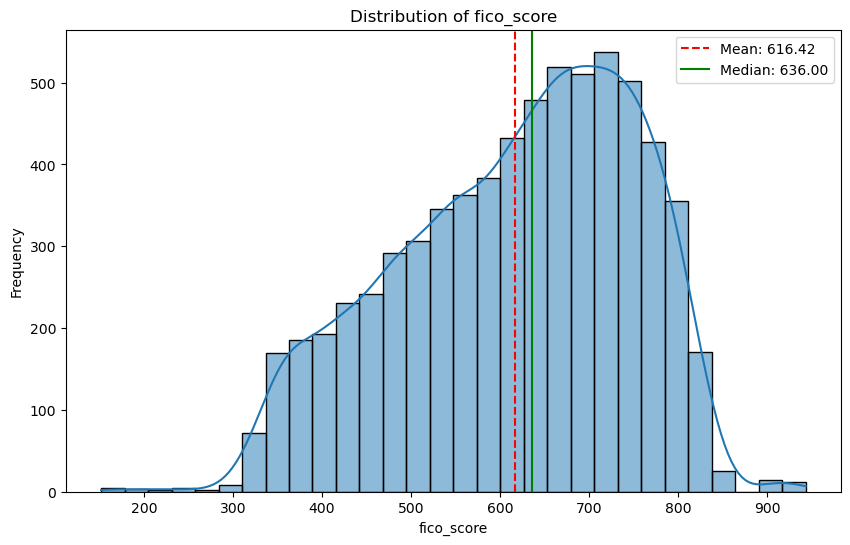

In [14]:
mean_value = data['fico_score'].mean()
median_value = data['fico_score'].median()
std_dev = data['fico_score'].std()
skewness = data['fico_score'].skew()
kurtosis = data['fico_score'].kurt()

print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_dev}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

plt.figure(figsize=(10, 6))
sns.histplot(data['fico_score'], kde=True, bins=30)
plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='g', linestyle='-', label=f'Median: {median_value:.2f}')
plt.title('Distribution of fico_score')
plt.xlabel('fico_score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [15]:
missing_fico_data = data[data['fico_score'].isna()]

missing_fico_data[['earliest_credit_account', 'account_open_date']].describe()

,earliest_credit_account,account_open_date
count,210,210
mean,2019-11-26 11:05:08.571428608,2022-03-30 04:00:00
min,2014-10-29 00:00:00,2019-10-27 00:00:00
25%,2017-07-28 12:00:00,2020-12-03 12:00:00
50%,2020-02-15 12:00:00,2022-01-13 12:00:00
75%,2022-02-19 18:00:00,2023-09-08 12:00:00
max,2024-10-12 00:00:00,2024-10-23 00:00:00


C:\Users\hcham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hcham\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


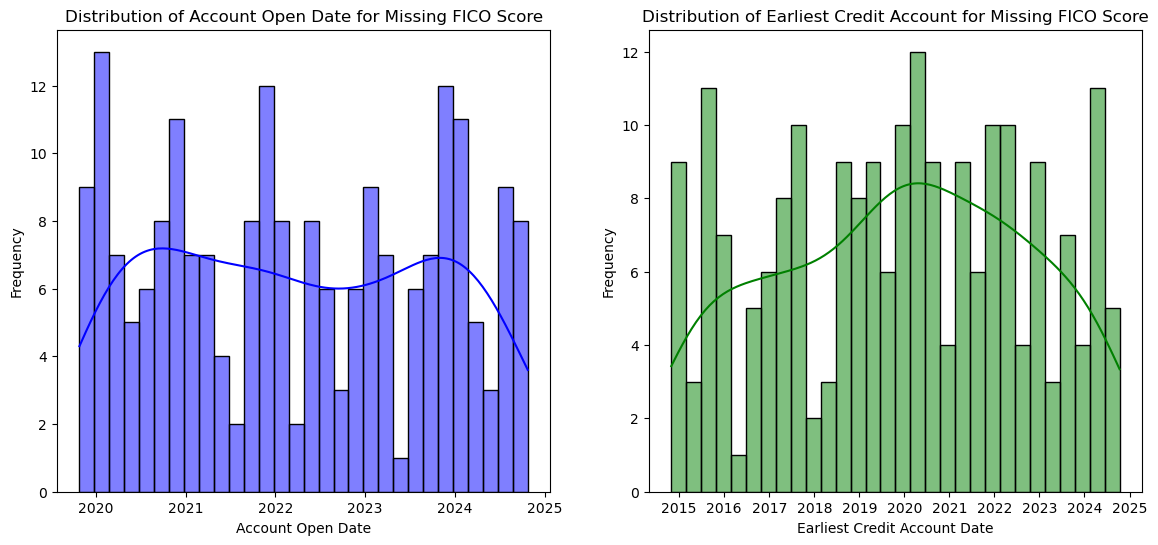

In [16]:
plt.figure(figsize=(14, 6))

# Plotting account_open_date distribution
plt.subplot(1, 2, 1)
sns.histplot(missing_fico_data['account_open_date'], kde=True, color='blue', bins=30)
plt.title('Distribution of Account Open Date for Missing FICO Score')
plt.xlabel('Account Open Date')
plt.ylabel('Frequency')

# Plotting earliest_credit_account distribution
plt.subplot(1, 2, 2)
sns.histplot(missing_fico_data['earliest_credit_account'], kde=True, color='green', bins=30)
plt.title('Distribution of Earliest Credit Account for Missing FICO Score')
plt.xlabel('Earliest Credit Account Date')
plt.ylabel('Frequency')

plt.show()

- The missing values in the `fico_score` variable do not show any clear pattern related to account dates or ages, suggesting that they are likely due to data entry errors. Since the number of missing values is small and does not seem to follow a specific trend, these rows have been removed to ensure the dataset remains accurate and reliable for analysis.

In [17]:
# Drop rows where 'fico_score' is missing
data_after_dropped_by_fico_score = data.dropna(subset=['fico_score'])

In [18]:
# Summary of missing values in each column
missing_summary = data_after_dropped_by_fico_score.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

unusual_submission_pattern       889
number_of_delinquent_accounts    678
dtype: int64


#### 3.2.1 - Out of range values

- It was observed that there are values out of the range 300 - 850.

In [19]:
invalid_fico = data_after_dropped_by_fico_score[(data_after_dropped_by_fico_score['fico_score'] < 300) | (data_after_dropped_by_fico_score['fico_score'] > 850)]
print(f"Number of invalid FICO scores: {len(invalid_fico)}")
invalid_fico.head()

Number of invalid FICO scores: 42


,account_open_date,age,location,occupation,income_level,fico_score,delinquency_status,charge_off_status,number_of_credit_applications,debt_to_income_ratio,...,number_of_delinquent_accounts,number_of_defaulted_accounts,earliest_credit_account,recent_trade_activity,new_accounts_opened_last_12months,multiple_applications_short_time_period,unusual_submission_pattern,applications_submitted_during_odd_hours,watchlist_blacklist_flag,public_records_flag
131,2022-02-26,24,Miami,Software Developer,9972,920.0,98,1,6,1.472118,...,NaN,2,2020-10-05,2024-01-28,3,1,True,1,0,0
161,2024-08-11,26,Houston,Other,6959,923.0,104,1,2,1.753587,...,3.0,1,2023-12-28,2024-02-08,3,1,True,0,0,0
862,2024-02-19,46,Miami,Banker,3202,938.0,0,0,2,1.842488,...,0.0,0,2024-01-12,2024-06-05,0,0,NaN,0,0,0
908,2021-03-25,48,Seattle,Accountant,39792,278.0,0,0,1,2.266673,...,0.0,0,2020-03-27,2023-11-12,0,0,False,0,0,0
920,2024-05-03,34,Boston,Other,7897,906.0,0,0,1,0.982923,...,0.0,0,2021-05-19,2024-04-17,0,0,False,0,0,1


In [20]:
# Remove rows where 'fico_score' is less than 300 or greater than 850
data_after_dropped_by_fico_score = data_after_dropped_by_fico_score[(data_after_dropped_by_fico_score['fico_score'] >= 300) & (data_after_dropped_by_fico_score['fico_score'] <= 850)]

In [21]:
# Summary of missing values in each column
missing_summary = data_after_dropped_by_fico_score.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

unusual_submission_pattern       882
number_of_delinquent_accounts    674
dtype: int64


To handle missing values of `unusual_submission_pattern` and `number_of_delinquent_accounts` we are going to use imputations methods.However to prevent **data leakage**  **(Train-Test Contamination)** , we split the data set in to train and test and trained the imputation model using trainig data only

In [22]:
train_data, test_data = train_test_split(data_after_dropped_by_fico_score, test_size=0.2, random_state=1)
train_data.to_csv("../data/train_data_before_usp.csv", index=False)
test_data.to_csv("../data/test_data_before_usp.csv", index=False)

### 3.3 - `unusual_submission_pattern`
- `unusual_submission_pattern` has 882 missing values. This is about 13% of the data. So if we remove those that would affect the dataset a lot. So we choose to impute this with some value by analyzing its relationship with other variables 

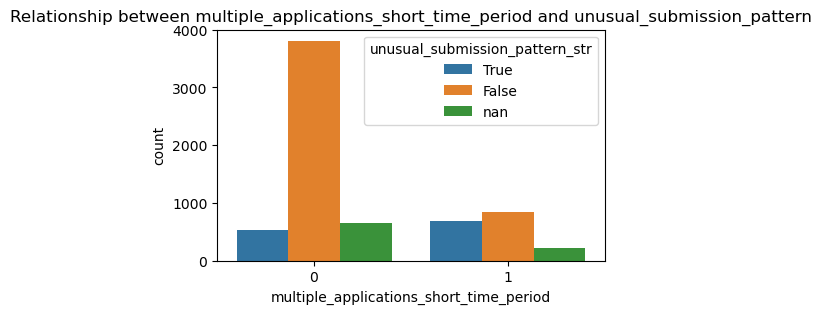

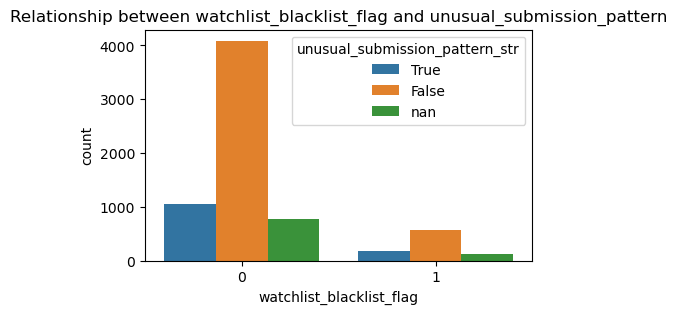

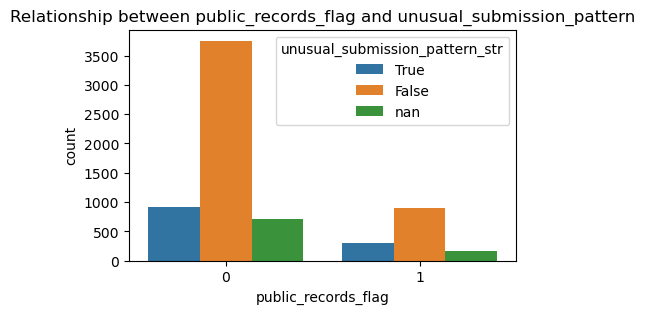

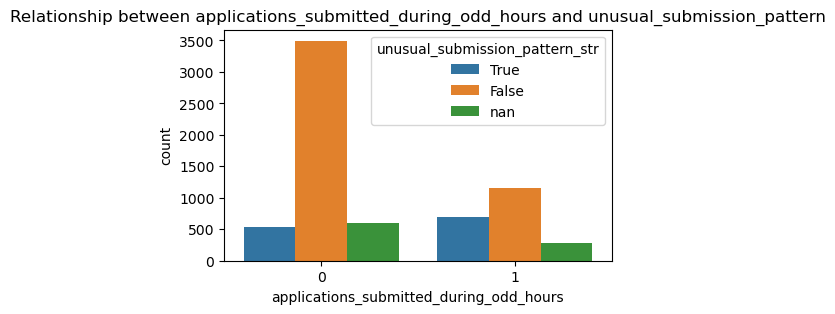

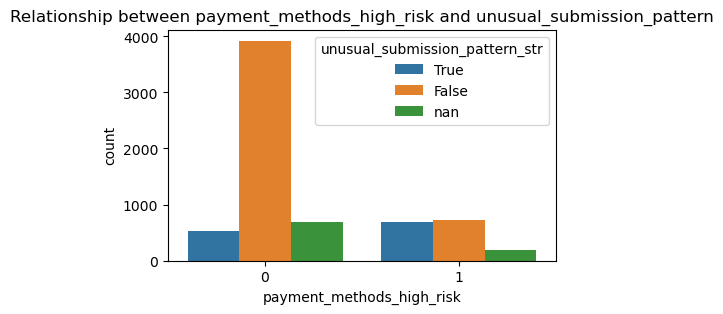

In [23]:
# 1. Visualizing realted categorical variables against 'unusual_submission_pattern'

# Convert 'unusual_submission_pattern' to a string
data_after_dropped_by_fico_score['unusual_submission_pattern_str'] = data_after_dropped_by_fico_score['unusual_submission_pattern'].astype(str)

features = ['multiple_applications_short_time_period', 'watchlist_blacklist_flag', 'public_records_flag','applications_submitted_during_odd_hours','payment_methods_high_risk']

for feature in features:
    plt.figure(figsize=(5, 3))
    sns.countplot(data=data_after_dropped_by_fico_score, x=feature, hue='unusual_submission_pattern_str')
    plt.title(f'Relationship between {feature} and unusual_submission_pattern')
    plt.show()

- We can observe a moderate data imbalance in the classes

In [28]:
# Remove rows where the target variable has missing values
train_data_cleaned = train_data.dropna(subset=['unusual_submission_pattern']).copy()
train_data_cleaned['unusual_submission_pattern'] = train_data_cleaned['unusual_submission_pattern'].astype(int)
print(train_data_cleaned['unusual_submission_pattern'].dtypes)
print(train_data_cleaned['unusual_submission_pattern'].unique())
print(train_data_cleaned['unusual_submission_pattern'].isna().sum())

int32
[1 0]
0


In [30]:
# 2. Chi-Square Test for realted features 

for feature in features:
    contingency_table = pd.crosstab(data_after_dropped_by_fico_score[feature], data_after_dropped_by_fico_score['unusual_submission_pattern_str'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {feature}:\n p-value: {p_value}")

Chi-square test for multiple_applications_short_time_period:
 p-value: 2.384929324947626e-162
Chi-square test for watchlist_blacklist_flag:
 p-value: 0.07758226054883027
Chi-square test for public_records_flag:
 p-value: 0.00011379433191355623
Chi-square test for applications_submitted_during_odd_hours:
 p-value: 3.4468243970697715e-100
Chi-square test for payment_methods_high_risk:
 p-value: 2.24738786090805e-193


In [31]:
# 3. Correlation Analysis for realted features 
features = ['multiple_applications_short_time_period', 'watchlist_blacklist_flag', 'public_records_flag','applications_submitted_during_odd_hours','payment_methods_high_risk']
target = 'unusual_submission_pattern'

# Calculate Pearson correlation for each binary feature with the target
correlations = {}
for feature in features:
    corr = data_after_dropped_by_fico_score[feature].corr(data_after_dropped_by_fico_score[target]) 
    correlations[feature] = corr

# Sort the correlations in descending order
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Display the top features based on correlation with the target
top_features = [x[0] for x in sorted_correlations[:3]]  
print(f"Top Features Based on Pearson Correlation: {top_features}")



Top Features Based on Pearson Correlation: ['payment_methods_high_risk', 'multiple_applications_short_time_period', 'applications_submitted_during_odd_hours']


- According to the above analysis due to features `multiple_applications_short_time_period`, `applications_submitted_during_odd_hours`, and `payment_methods_high_risk`, indicated a significant chi-square test results and correlations,There for a Weighted KNN imputation was chosen for handling missing values in the `unusual_submission_pattern` feature due to its ability to capture complex relationships. Weighted KNN was choosed due to inbalance of values

### 3.1.1 Using XGBClassifier to impute missing values for `unusual_submission_pattern`

In [32]:
features = ['multiple_applications_short_time_period', 
            'applications_submitted_during_odd_hours', 
            'payment_methods_high_risk']
target = 'unusual_submission_pattern'

In [33]:
train_data_only_na = train_data[train_data[target].isna()].copy()
train_data_without_na = train_data[train_data[target].notna()].copy()

test_data_only_na = test_data[test_data[target].isna()].copy()
test_data_without_na = test_data[test_data[target].notna()].copy()

train_data_without_na[target] = train_data_without_na[target].astype(int)
test_data_without_na[target] = test_data_without_na[target].astype(int)

In [34]:
X_train = train_data_without_na[features]
y_train = train_data_without_na[target]

X_test = test_data_without_na[features]

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model2 = XGBClassifier(scale_pos_weight=scale_pos_weight,random_state=1)
xgb_model2.fit(X_train, y_train)

X_train_only_na = train_data_only_na[features]
X_test_only_na = test_data_only_na[features]

probs_train_only_na = xgb_model2.predict_proba(X_train_only_na)[:, 1]
probs_test_only_na = xgb_model2.predict_proba(X_test_only_na)[:, 1]

predicted_train_only_na  = (probs_train_only_na >= 0.72).astype(int)
predicted_test_only_na  = (probs_test_only_na >= 0.72).astype(int)

In [35]:
train_data_only_na['unusual_submission_pattern'] = predicted_train_only_na
test_data_only_na['unusual_submission_pattern'] = predicted_test_only_na

usp_imputed_train_data = pd.concat([train_data_without_na, train_data_only_na])
usp_imputed_test_data = pd.concat([test_data_without_na, test_data_only_na])

usp_imputed_train_data.sort_index(inplace=True)
usp_imputed_test_data.sort_index(inplace=True)

In [36]:
# Full Dataset
full_usp_imputed_dataset = pd.concat([usp_imputed_train_data, usp_imputed_test_data])

In [37]:
# Summary of missing values in each column
missing_summary = full_usp_imputed_dataset.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

number_of_delinquent_accounts    674
dtype: int64


In [38]:
usp_imputed_train_data.to_csv("../data/usp_imputed_train_data.csv", index=False)
usp_imputed_test_data.to_csv("../data/usp_imputed_test_data.csv", index=False)

### 3.4 - `number_of_delinquent_accounts`

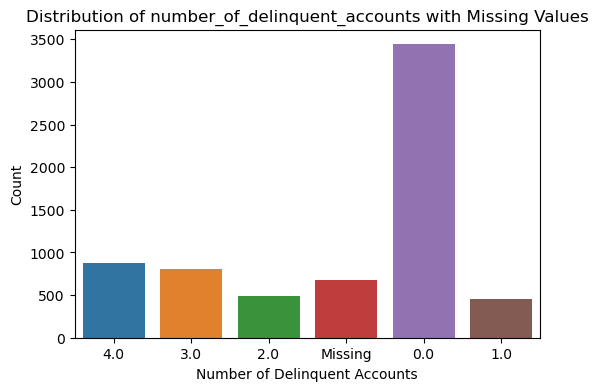

In [39]:
full_usp_imputed_dataset['number_of_delinquent_accounts_filled'] = full_usp_imputed_dataset['number_of_delinquent_accounts'].fillna('Missing')

plt.figure(figsize=(6, 4))
sns.countplot(x='number_of_delinquent_accounts_filled', data=full_usp_imputed_dataset)
plt.title('Distribution of number_of_delinquent_accounts with Missing Values')
plt.xlabel('Number of Delinquent Accounts')
plt.ylabel('Count')
plt.show()

In [40]:
full_usp_imputed_dataset['number_of_delinquent_accounts'].mean()

1.2140270003292724

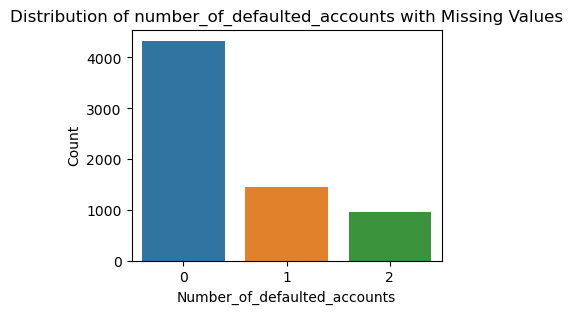

In [41]:
plt.figure(figsize=(4, 3))
sns.countplot(x='number_of_defaulted_accounts', data=full_usp_imputed_dataset)
plt.title('Distribution of number_of_defaulted_accounts with Missing Values')
plt.xlabel('Number_of_defaulted_accounts')
plt.ylabel('Count')
plt.show()

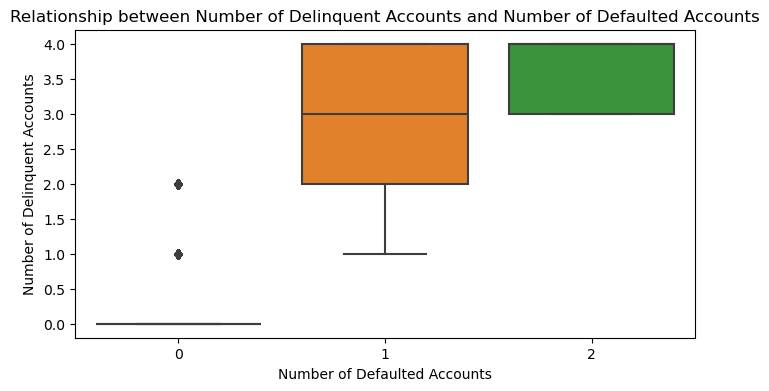

In [42]:
# Checking the distribution of 'number_of_delinquent_accounts' with 'number_of_defaulted_accounts'
plt.figure(figsize=(8, 4))
sns.boxplot(x='number_of_defaulted_accounts', y='number_of_delinquent_accounts', data=full_usp_imputed_dataset)
plt.title('Relationship between Number of Delinquent Accounts and Number of Defaulted Accounts')
plt.xlabel('Number of Defaulted Accounts')
plt.ylabel('Number of Delinquent Accounts')
plt.show()

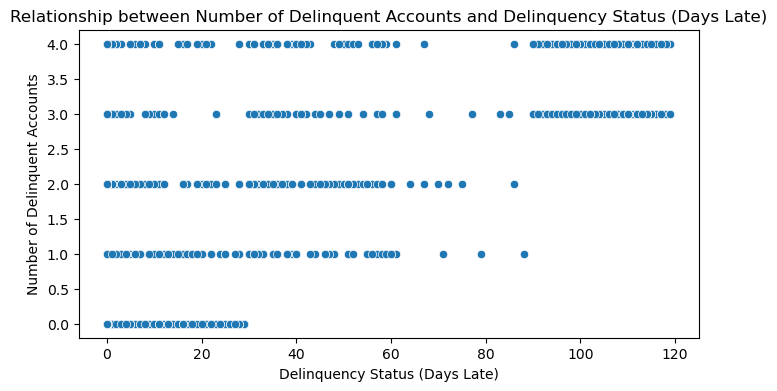

In [43]:
# Checking the distribution of 'number_of_delinquent_accounts' with 'delinquency_status'
plt.figure(figsize=(8, 4))
sns.scatterplot(x='delinquency_status', y='number_of_delinquent_accounts', data=full_usp_imputed_dataset)
plt.title('Relationship between Number of Delinquent Accounts and Delinquency Status (Days Late)')
plt.xlabel('Delinquency Status (Days Late)')
plt.ylabel('Number of Delinquent Accounts')
plt.show()

C:\Users\hcham\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


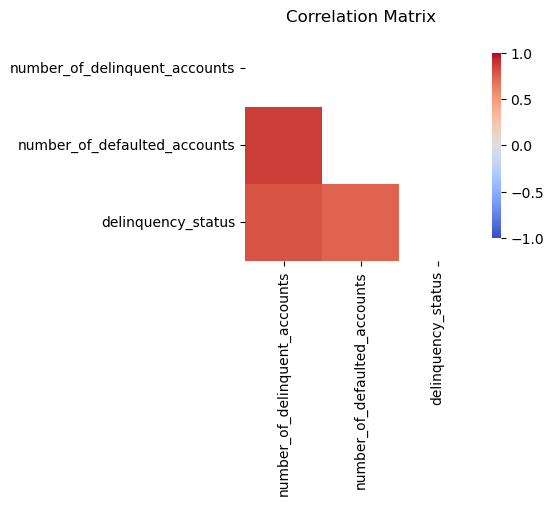

In [44]:
# Calculate the correlation matrix
correlation_matrix = full_usp_imputed_dataset[['number_of_delinquent_accounts', 'number_of_defaulted_accounts', 'delinquency_status']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.show()


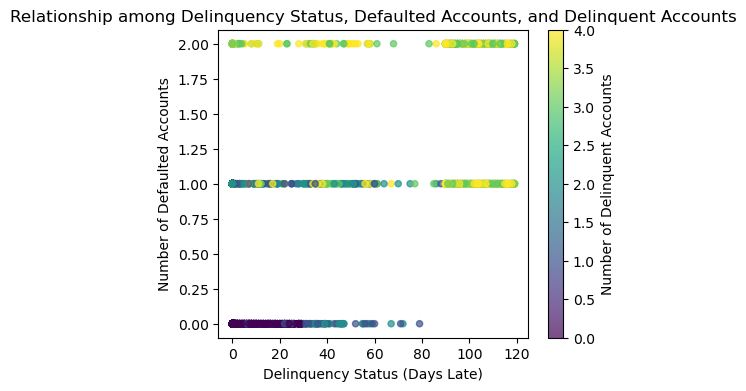

In [45]:
plt.figure(figsize=(5, 4))
scatter = plt.scatter(
    full_usp_imputed_dataset['delinquency_status'],
    full_usp_imputed_dataset['number_of_defaulted_accounts'],
    c=full_usp_imputed_dataset['number_of_delinquent_accounts'],
    cmap='viridis', 
    s=20,  
    alpha=0.7  
)
plt.colorbar(scatter, label='Number of Delinquent Accounts')
plt.title('Relationship among Delinquency Status, Defaulted Accounts, and Delinquent Accounts')
plt.xlabel('Delinquency Status (Days Late)')
plt.ylabel('Number of Defaulted Accounts')
plt.show()

### 3.4.1 Traning XGBRegressor to impute missing values for `number_of_delinquent_accounts`

In [46]:
# Split data into rows with and without missing 'number_of_delinquent_accounts'
data_complete_train = usp_imputed_train_data[usp_imputed_train_data['number_of_delinquent_accounts'].notna()]
data_complete_test = usp_imputed_test_data[usp_imputed_test_data['number_of_delinquent_accounts'].notna()]
data_missing_train = usp_imputed_train_data[usp_imputed_train_data['number_of_delinquent_accounts'].isna()]
data_missing_test = usp_imputed_test_data[usp_imputed_test_data['number_of_delinquent_accounts'].isna()]

# Define predictor and target variables
X = data_complete_train[['number_of_defaulted_accounts', 'delinquency_status']]
y = data_complete_train['number_of_delinquent_accounts']

# Split complete data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Define the regression model
xgb_regressor = XGBRegressor(eval_metric='rmse')

# Train the model
xgb_regressor.fit(X_train, y_train)

# Predict
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse) 
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Absolute Error: 0.39
Mean Squared Error: 0.34
Root Mean Squared Error: 0.59
R-squared: 0.86


The model performs well for imputing missing `number_of_delinquent_accounts` values, with an **R-squared** of 0.86, indicating it explains 87% of the variance. The low **Mean Absolute Error (0.39)** and **Mean Squared Error (0.34)** show that the predictions are accurate, and the **Root Mean Squared Error (0.59)** suggests minimal prediction errors. These results demonstrate the model's strong predictive ability, making it a reliable tool for imputing missing values in your dataset.

### 3.4.2 Imputing missing values for `number_of_delinquent_accounts` using XGBRegressor

In [47]:
# Prepare missing data for prediction
X_missing_train = data_missing_train[['number_of_defaulted_accounts', 'delinquency_status']]
X_missing_test = data_missing_test[['number_of_defaulted_accounts', 'delinquency_status']]

# Predict the missing values
data_missing_train.loc[:, 'number_of_delinquent_accounts'] = xgb_regressor.predict(X_missing_train).round()
data_missing_test.loc[:, 'number_of_delinquent_accounts'] = xgb_regressor.predict(X_missing_test).round()

# Clip values to ensure they are within the valid range (0 to 4)
data_missing_train.loc[:, 'number_of_delinquent_accounts'] = data_missing_train['number_of_delinquent_accounts'].clip(0, 4)
data_missing_test.loc[:, 'number_of_delinquent_accounts'] = data_missing_test['number_of_delinquent_accounts'].clip(0, 4)

# Combine the data back
data_imputed_train = pd.concat([data_complete_train, data_missing_train])
data_imputed_test = pd.concat([data_complete_test, data_missing_test])

In [48]:
data_imputed_train.to_csv("../data/preprocessed_train_data.csv", index=False)
data_imputed_test.to_csv("../data/preprocessed_test_data.csv", index=False)

In [49]:
# Full Dataset
full_imputed_dataset = pd.concat([data_imputed_train, data_imputed_test])

In [50]:
# Summary of missing values in each column
missing_summary = full_imputed_dataset.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

Series([], dtype: int64)


In [51]:
full_imputed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6748 entries, 0 to 6983
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   account_open_date                        6748 non-null   datetime64[ns]
 1   age                                      6748 non-null   int64         
 2   location                                 6748 non-null   category      
 3   occupation                               6748 non-null   category      
 4   income_level                             6748 non-null   int64         
 5   fico_score                               6748 non-null   float64       
 6   delinquency_status                       6748 non-null   int64         
 7   charge_off_status                        6748 non-null   int32         
 8   number_of_credit_applications            6748 non-null   int64         
 9   debt_to_income_ratio                     6748 

In [52]:
full_imputed_dataset.describe()

,account_open_date,age,income_level,fico_score,delinquency_status,charge_off_status,number_of_credit_applications,debt_to_income_ratio,payment_methods_high_risk,max_balance,...,number_of_delinquent_accounts,number_of_defaulted_accounts,earliest_credit_account,recent_trade_activity,new_accounts_opened_last_12months,multiple_applications_short_time_period,unusual_submission_pattern,applications_submitted_during_odd_hours,watchlist_blacklist_flag,public_records_flag
count,6748,6748.000000,6748.000000,6748.000000,6748.000000,6748.000000,6748.000000,6748.000000,6748.000000,6748.000000,...,6748.000000,6748.000000,6748,6748,6748.000000,6748.000000,6748.000000,6748.000000,6748.000000,6748.000000
mean,2022-04-21 03:02:14.439834368,46.148488,23717.458062,616.211618,25.252964,0.260670,1.811648,1.477336,0.237404,50462.244115,...,1.209247,0.499555,2019-11-04 13:39:13.764077824,2024-04-25 18:26:02.062833664,1.383669,0.258447,0.207024,0.314908,0.126260,0.201986
min,2019-10-25 00:00:00,18.000000,2000.000000,301.000000,0.000000,0.000000,1.000000,0.438413,0.000000,930.516529,...,0.000000,0.000000,2014-10-25 00:00:00,2023-10-25 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021-01-21 18:00:00,32.000000,6921.750000,521.000000,0.000000,0.000000,1.000000,1.052407,0.000000,25530.592888,...,0.000000,0.000000,2017-05-08 18:00:00,2024-01-26 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2022-04-13 00:00:00,46.000000,14976.000000,635.500000,0.000000,0.000000,1.000000,1.320511,0.000000,44815.552299,...,0.000000,0.000000,2019-11-17 00:00:00,2024-04-24 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-07-19 00:00:00,61.000000,38267.500000,722.000000,29.000000,1.000000,1.000000,1.719710,0.000000,70145.742751,...,3.000000,1.000000,2022-04-29 00:00:00,2024-07-28 00:00:00,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,2024-10-24 00:00:00,74.000000,99957.000000,848.000000,119.000000,1.000000,10.000000,9.975930,1.000000,999922.083300,...,4.000000,2.000000,2024-10-24 00:00:00,2024-10-24 00:00:00,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,16.411338,21872.292686,130.181643,42.736714,0.439033,1.934514,0.684346,0.425523,50151.749003,...,1.562802,0.730357,NaN,NaN,1.594867,0.437813,0.405203,0.464514,0.332166,0.401511


## 4. Saving the final Worksheet

In [53]:
full_imputed_dataset.to_csv("../data/pre_prpocessed_dataset.csv", index=False)